# 초기 랜덤 값을 음수 양수 범위로 설정함
# 변수 설정

In [19]:
batch_size = 50
one_looptime = int(55000/batch_size)

learning_rate_conv = 0.03
learning_rate_fc = 0.03
name = 'batch50_lr001'
save_path = '/data/cnn_std1_'

In [2]:
# learn_count = one_looptime*5*30
learn_count = one_looptime

# batch_size = 50
# batch 후 learning
![image.png](attachment:image.png)

In [3]:
# 패키지 import
import tensorflow as tf
import time
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.cmap'] = 'Greys'

import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(precision=2)

In [22]:
# 필요한 함수 정의
def padding(X, image_size=28):
    padd = np.zeros((image_size + filter_size_half*2,image_size + filter_size))

    padd[filter_size_half : filter_size_half + image_size,
         filter_size_half : filter_size_half + image_size] = X

    return padd


def conv_oneInput(X_padding, W, b, image_size=28, strides=1):
    conv_size = int(image_size/strides)
    output = np.zeros((filter_num, conv_size, conv_size))

    for k in range(filter_num):
        for i in range(conv_size):
            for j in range(conv_size):
                i = i*strides
                j = j*strides
                output[k,i,j] = np.sum(X_padding[i:i+filter_size, j:j+filter_size] * W[k])+ b[0,k]
    return output

def conv_n_Input(X_padding, W, b, image_size=28, strides=1):
    conv_size = int(image_size/strides)
    output = np.zeros((filter_num, conv_size, conv_size))

    for k in range(filter_num):
        for i in range(conv_size):
            for j in range(conv_size):
                i = i*strides
                j = j*strides
                output[k,i,j] = np.sum(X_padding[k,i:i+filter_size, j:j+filter_size] *
                                       W[k]) + b[k]
    return output

def fc_output(X_conv, W_fc, b_fc):
    output = np.zeros((1,output_num))
    
    for p in range(output_num):
        output[0,p] = np.sum(X_conv*W_fc[:,:,:,p]) + b_fc[0,p]
    
    return output

def diff_fc(i, j, TeachLabel):
    diff = np.zeros((output_num))
    T_index = TeachLabel.argmax()
    diff += 1/X_output[T_index]

    for q in range(output_num):
        diff[q] = 1/X_output[T_index]
        
def sigmoid(X):   
    return 1/(np.exp(-X/3) + 1)

In [5]:
# data 불러오기
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(55000, 784)
(55000, 10)
(10000, 784)
(10000, 10)
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


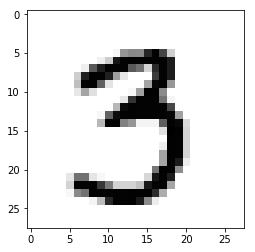

In [6]:
# data 확인하기
print (mnist.train.images.shape)
print (mnist.train.labels.shape)

print (mnist.test.images.shape)
print (mnist.test.labels.shape)

idx = 10007
example_image = mnist.train.images[idx]
example_image_reshaped = example_image.reshape((28, 28)) # Can't render a line of 784 numbers
#len(example_image_reshaped.reshape((28*28)))
example_label = mnist.train.labels[idx]
print(example_label)
plt.imshow(example_image_reshaped)

In [23]:
# 변수 생성
img_size = 28
filter_num = 4
filter_size = 5
output_num = 2

# int(a) 하면 a의 소수점이 버림 된다. 
img_size_half = int(img_size/2)
filter_size_half = int(filter_size/2)

W_conv_shape = (filter_num, filter_size, filter_size)
b_conv_shape = (1,filter_num)
W_fc_shape = (filter_num, img_size, img_size, output_num)
b_fc_shape = (1,output_num)

params = ['W_conv', 'b_conv', 'W_fc', 'b_fc', 
          'W_conv_ing', 'b_conv_ing', 'W_fc_ing', 'b_fc_ing', 
          'error']
data_params = {'W_conv' : 2*np.random.rand(W_conv_shape[0], W_conv_shape[1], W_conv_shape[2]) - 1,
               'b_conv' : 2*np.random.rand(b_conv_shape[0], b_conv_shape[1]) - 1,
               'W_fc' : 2*np.random.rand(W_fc_shape[0], W_fc_shape[1], W_fc_shape[2], W_fc_shape[3]) - 1,
               'b_fc' : 2*np.random.rand(b_fc_shape[0],b_fc_shape[1]) - 1,
               'W_conv_ing' : [],
               'b_conv_ing' : [],
               'W_fc_ing' : [],
               'b_fc_ing' : [],
               'error' : []}

# data 불러오기

# 불러 불러와
for i in range(len(params)):
    data_params.update({params[i]: 
                        np.load(save_path + name +'_' + params[i] + '.npy')})

# list로 바꾸기
data_params['error'] = list(data_params['error'])
W_conv_ing = []
b_conv_ing = []
W_fc_ing = []
b_fc_ing = []

for i in range(len(data_params['W_fc_ing'])):
    W_conv_ing.append(data_params['W_conv_ing'][i])
    b_conv_ing.append(data_params['b_conv_ing'][i])
    W_fc_ing.append(data_params['W_fc_ing'][i])
    b_fc_ing.append(data_params['b_fc_ing'][i])

data_params['W_conv_ing'] = W_conv_ing
data_params['b_conv_ing'] = b_conv_ing
data_params['W_fc_ing'] = W_fc_ing
data_params['b_fc_ing'] = b_fc_ing

# 학습

In [9]:
# 0 과 1만 추출하기
a_0 = mnist.train.labels[:,0]
b_0 = list(np.where(a_0==1)[0])

a_1 = mnist.train.labels[:,1]
b_1 = list(np.where(a_1==1)[0])

list_idx = b_0 + b_1
idxsort = sorted(list_idx)
len_idxsort = len(idxsort)

X_inputappend = []
X_teachappend = []

for q in idxsort:
    X_input_01 = mnist.train.images[q].reshape((28,28))
    X_teach_01 = mnist.train.labels[q][:2].reshape((1,2))
    X_inputappend.append(X_input_01)
    X_teachappend.append(X_teach_01)

In [24]:
# input -> output
print('start')
start = time.time()
for n in range(learn_count):
    #n += 200
    nn = n*batch_size
    error = 0
    accuracy = 0
    del_W_fc = np.zeros(W_fc_shape)
    del_b_fc = np.zeros(b_fc_shape)
    del_W_conv = np.zeros(W_conv_shape)
    del_b_conv = np.zeros(b_conv_shape)
    """
    if n%one_looptime == 0:
        data_params['W_conv_ing'].append(data_params['W_conv']*1)
        data_params['b_conv_ing'].append(data_params['b_conv']*1)
        data_params['W_fc_ing'].append(data_params['W_fc']*1)
        data_params['b_fc_ing'].append(data_params['b_fc']*1)
    """
    for q in range(batch_size):
        
        # input -> output
        idx = (q+nn)%len_idxsort
        X_input = mnist.train.images[idxsort[idx]].reshape((28,28))
        X_teach = mnist.train.labels[idxsort[idx], :2].reshape((1,output_num))

        X_padding = padding(X_input)
        
        X_conv = conv_oneInput(X_padding, data_params['W_conv'], data_params['b_conv'])
        X_conv_sigmoid = sigmoid(X_conv)
        
        X_output = fc_output(X_conv_sigmoid, data_params['W_fc'], data_params['b_fc'])
        X_sigmoid = sigmoid(X_output)

        # output -> input
        accuracy += np.argmax(X_sigmoid) == np.argmax(X_teach)
        
        # 1층 delta
        del_output_sig = X_sigmoid - X_teach
        error += 0.5 * np.sum(del_output_sig * del_output_sig)
        
        del_output = (X_sigmoid*(1-X_sigmoid)) * del_output_sig
        
        # 1층 del_w
        for p in range(output_num):
            del_W_fc[:,:,:,p] += X_conv * del_output[0,p]
        del_b_fc += del_output
        
        # 2층 delta
        del_conv_sig = np.zeros(X_conv_sigmoid.shape)
        for k in range(filter_num):
            for p in range(output_num):
                del_conv_sig[k] += data_params['W_fc'][k,:,:,p] * del_output[0,p]
                
        del_conv = (X_conv_sigmoid*(1-X_conv_sigmoid)) * del_conv_sig
        
        # 2층 del_w
        for k in range(filter_num):
            for h in range(filter_size):
                for s in range(filter_size):
                    del_W_conv[k,h,s] += np.sum(X_padding[h:h+img_size, s:s+img_size] * del_conv[k])
            del_b_conv[0,k] += np.sum(del_conv[k])
        
    data_params['W_fc'] -= learning_rate_fc * del_W_fc/batch_size
    data_params['b_fc'] -= learning_rate_fc * del_b_fc/batch_size

    data_params['W_conv'] -= learning_rate_conv * del_W_conv/batch_size
    data_params['b_conv'] -= learning_rate_conv * del_b_conv/batch_size

    error = error/batch_size
    data_params['error'].append(error)
    
    print("batch {0:4d}\t Error : {1:.3f}\t accuracy : {2:.3f}".format(n + 1, error, accuracy/batch_size))
    
    if n%one_looptime == 0:
        print("loop {0:4d}\t Error : {1:.3f}\t accuracy : {2:.3f}".format(n//one_looptime + 1, error, accuracy/batch_size))
        
    time.sleep(0.001)
    
tt = time.time() - start
print("{0:.0f}시간 {1:.0f}분 {2:.0f}초".format((tt//60)//60, (tt//60)%60, tt%60))

start
batch    1	 Error : 0.449	 accuracy : 0.540
loop    1	 Error : 0.449	 accuracy : 0.540
batch    2	 Error : 0.447	 accuracy : 0.540
batch    3	 Error : 0.466	 accuracy : 0.520
batch    4	 Error : 0.521	 accuracy : 0.460
batch    5	 Error : 0.520	 accuracy : 0.460
batch    6	 Error : 0.533	 accuracy : 0.440
batch    7	 Error : 0.541	 accuracy : 0.420
batch    8	 Error : 0.418	 accuracy : 0.540
batch    9	 Error : 0.421	 accuracy : 0.520
batch   10	 Error : 0.426	 accuracy : 0.460
batch   11	 Error : 0.382	 accuracy : 0.460
batch   12	 Error : 0.403	 accuracy : 0.400
batch   13	 Error : 0.350	 accuracy : 0.460
batch   14	 Error : 0.292	 accuracy : 0.560
batch   15	 Error : 0.304	 accuracy : 0.540
batch   16	 Error : 0.453	 accuracy : 0.280
batch   17	 Error : 0.334	 accuracy : 0.460
batch   18	 Error : 0.324	 accuracy : 0.480
batch   19	 Error : 0.339	 accuracy : 0.460
batch   20	 Error : 0.317	 accuracy : 0.500
batch   21	 Error : 0.281	 accuracy : 0.560
batch   22	 Error : 0.308	 

batch  187	 Error : 0.273	 accuracy : 0.460
batch  188	 Error : 0.260	 accuracy : 0.500
batch  189	 Error : 0.242	 accuracy : 0.520
batch  190	 Error : 0.279	 accuracy : 0.460
batch  191	 Error : 0.286	 accuracy : 0.440
batch  192	 Error : 0.245	 accuracy : 0.520
batch  193	 Error : 0.239	 accuracy : 0.540
batch  194	 Error : 0.277	 accuracy : 0.460
batch  195	 Error : 0.283	 accuracy : 0.460
batch  196	 Error : 0.246	 accuracy : 0.520
batch  197	 Error : 0.225	 accuracy : 0.560
batch  198	 Error : 0.285	 accuracy : 0.440
batch  199	 Error : 0.235	 accuracy : 0.540
batch  200	 Error : 0.304	 accuracy : 0.400
batch  201	 Error : 0.242	 accuracy : 0.540
batch  202	 Error : 0.323	 accuracy : 0.360
batch  203	 Error : 0.269	 accuracy : 0.480
batch  204	 Error : 0.285	 accuracy : 0.440
batch  205	 Error : 0.261	 accuracy : 0.480
batch  206	 Error : 0.232	 accuracy : 0.540
batch  207	 Error : 0.270	 accuracy : 0.460
batch  208	 Error : 0.265	 accuracy : 0.480
batch  209	 Error : 0.276	 accur

batch  374	 Error : 0.008	 accuracy : 1.000
batch  375	 Error : 0.007	 accuracy : 1.000
batch  376	 Error : 0.022	 accuracy : 0.980
batch  377	 Error : 0.008	 accuracy : 1.000
batch  378	 Error : 0.006	 accuracy : 1.000
batch  379	 Error : 0.013	 accuracy : 1.000
batch  380	 Error : 0.027	 accuracy : 0.980
batch  381	 Error : 0.012	 accuracy : 1.000
batch  382	 Error : 0.008	 accuracy : 1.000
batch  383	 Error : 0.019	 accuracy : 0.980
batch  384	 Error : 0.017	 accuracy : 0.980
batch  385	 Error : 0.011	 accuracy : 1.000
batch  386	 Error : 0.006	 accuracy : 1.000
batch  387	 Error : 0.011	 accuracy : 1.000
batch  388	 Error : 0.011	 accuracy : 1.000
batch  389	 Error : 0.014	 accuracy : 1.000
batch  390	 Error : 0.016	 accuracy : 1.000
batch  391	 Error : 0.007	 accuracy : 1.000
batch  392	 Error : 0.021	 accuracy : 0.980
batch  393	 Error : 0.005	 accuracy : 1.000
batch  394	 Error : 0.013	 accuracy : 1.000
batch  395	 Error : 0.016	 accuracy : 1.000
batch  396	 Error : 0.007	 accur

batch  561	 Error : 0.006	 accuracy : 1.000
batch  562	 Error : 0.007	 accuracy : 1.000
batch  563	 Error : 0.019	 accuracy : 0.980
batch  564	 Error : 0.004	 accuracy : 1.000
batch  565	 Error : 0.023	 accuracy : 0.980
batch  566	 Error : 0.005	 accuracy : 1.000
batch  567	 Error : 0.003	 accuracy : 1.000
batch  568	 Error : 0.006	 accuracy : 1.000
batch  569	 Error : 0.007	 accuracy : 1.000
batch  570	 Error : 0.007	 accuracy : 0.980
batch  571	 Error : 0.010	 accuracy : 1.000
batch  572	 Error : 0.011	 accuracy : 1.000
batch  573	 Error : 0.017	 accuracy : 0.960
batch  574	 Error : 0.003	 accuracy : 1.000
batch  575	 Error : 0.005	 accuracy : 1.000
batch  576	 Error : 0.006	 accuracy : 1.000
batch  577	 Error : 0.019	 accuracy : 0.980
batch  578	 Error : 0.010	 accuracy : 1.000
batch  579	 Error : 0.006	 accuracy : 1.000
batch  580	 Error : 0.006	 accuracy : 1.000
batch  581	 Error : 0.003	 accuracy : 1.000
batch  582	 Error : 0.004	 accuracy : 1.000
batch  583	 Error : 0.004	 accur

batch  748	 Error : 0.001	 accuracy : 1.000
batch  749	 Error : 0.015	 accuracy : 0.980
batch  750	 Error : 0.007	 accuracy : 1.000
batch  751	 Error : 0.003	 accuracy : 1.000
batch  752	 Error : 0.017	 accuracy : 0.980
batch  753	 Error : 0.005	 accuracy : 1.000
batch  754	 Error : 0.002	 accuracy : 1.000
batch  755	 Error : 0.002	 accuracy : 1.000
batch  756	 Error : 0.002	 accuracy : 1.000
batch  757	 Error : 0.002	 accuracy : 1.000
batch  758	 Error : 0.002	 accuracy : 1.000
batch  759	 Error : 0.004	 accuracy : 1.000
batch  760	 Error : 0.003	 accuracy : 1.000
batch  761	 Error : 0.001	 accuracy : 1.000
batch  762	 Error : 0.005	 accuracy : 1.000
batch  763	 Error : 0.011	 accuracy : 0.980
batch  764	 Error : 0.007	 accuracy : 1.000
batch  765	 Error : 0.008	 accuracy : 1.000
batch  766	 Error : 0.003	 accuracy : 1.000
batch  767	 Error : 0.017	 accuracy : 0.980
batch  768	 Error : 0.002	 accuracy : 1.000
batch  769	 Error : 0.024	 accuracy : 0.960
batch  770	 Error : 0.001	 accur

batch  935	 Error : 0.002	 accuracy : 1.000
batch  936	 Error : 0.001	 accuracy : 1.000
batch  937	 Error : 0.002	 accuracy : 1.000
batch  938	 Error : 0.003	 accuracy : 1.000
batch  939	 Error : 0.001	 accuracy : 1.000
batch  940	 Error : 0.012	 accuracy : 0.980
batch  941	 Error : 0.004	 accuracy : 1.000
batch  942	 Error : 0.005	 accuracy : 1.000
batch  943	 Error : 0.002	 accuracy : 1.000
batch  944	 Error : 0.004	 accuracy : 1.000
batch  945	 Error : 0.002	 accuracy : 1.000
batch  946	 Error : 0.006	 accuracy : 1.000
batch  947	 Error : 0.007	 accuracy : 1.000
batch  948	 Error : 0.001	 accuracy : 1.000
batch  949	 Error : 0.003	 accuracy : 1.000
batch  950	 Error : 0.001	 accuracy : 1.000
batch  951	 Error : 0.002	 accuracy : 1.000
batch  952	 Error : 0.002	 accuracy : 1.000
batch  953	 Error : 0.005	 accuracy : 1.000
batch  954	 Error : 0.001	 accuracy : 1.000
batch  955	 Error : 0.001	 accuracy : 1.000
batch  956	 Error : 0.019	 accuracy : 0.980
batch  957	 Error : 0.007	 accur

# save data

In [10]:
# 데이터 저장
# list도 자동으로 array 저장됨
for ii in data_params.keys():
    np.save(save_path + name +'_' + ii + '.npy', data_params[ii])


In [11]:
print(len(data_params['error']))
print(len(data_params['W_fc_ing']))

995500
905


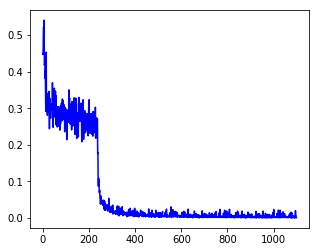

In [25]:
#plt.ylim(ymin=0)
plt.plot(data_params['error'],'b')

In [13]:
# test. accuracy check
accuracy_calc = np.zeros((len(mnist.test.images)))
test_num = 10000
not_correct = []

start = time.time()
for q in range(test_num):
    X_input = mnist.test.images[q].reshape((28,28))
    X_teach = mnist.test.labels[q].reshape((1,10))
    
    X_padding = padding(X_input)
        
    X_conv = conv_oneInput(X_padding, data_params['W_conv'], data_params['b_conv'])
    X_conv_sigmoid = sigmoid(X_conv)

    X_output = fc_output(X_conv_sigmoid, data_params['W_fc'], data_params['b_fc'])
    X_sigmoid = sigmoid(X_output)
    
    corr = np.argmax(X_sigmoid) == np.argmax(X_teach)
    accuracy_calc[q] = corr
    if not corr:
        not_correct.append(q)
    if q%100 == 0:
        print(q)
        
accuracy = np.average(accuracy_calc[0:test_num])
print(accuracy)

tt = time.time() - start
print("{0:.0f}분 {1:.0f}초".format(tt//60, tt%60))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
0.098
2분 8초


In [14]:
ing_accuracy_list = []
ing_not_correct_idx = []

try:
    ing_accuracy_list = np.load(save_path + name +'_ing_accuracy_list.npy')
    ing_not_correct_idx1 = np.load(save_path + name +'_ing_not_correct_idx.npy')
    ing_accuracy_list = list(ing_accuracy_list)
    
    for i in range(len(ing_not_correct_idx1)):
        ing_not_correct_idx.append([])
        ing_not_correct_idx[i] = ing_not_correct_idx1[i]
        
    print('try')
    
except:
    ing_accuracy_list = []
    ing_not_correct_idx = []
    print('except')

try


In [15]:
# test. accuracy check
accuracy_calc = np.zeros((len(mnist.test.images)))
accum_num = len(ing_accuracy_list)
   
start = time.time()
for ii in range(len(data_params['W_conv_ing']) - accum_num):
    ii += accum_num
    ing_not_correct_idx.append([])
    
    for q in range(len(accuracy_calc)):
        X_input = mnist.train.images[q].reshape((28,28))
        X_teach = mnist.train.labels[q].reshape((1,10))

        X_padding = padding(X_input)

        X_conv = conv_oneInput(X_padding, data_params['W_conv_ing'][ii], data_params['b_conv_ing'][ii])
        X_conv_sigmoid = sigmoid(X_conv)

        X_output = fc_output(X_conv_sigmoid, data_params['W_fc_ing'][ii], data_params['b_fc_ing'][ii])
        X_sigmoid = sigmoid(X_output)

        corr = np.argmax(X_sigmoid) == np.argmax(X_teach)
        accuracy_calc[q] = corr
        
        if not corr:
            ing_not_correct_idx[ii].append(q)
            
        if q%100 == 0:
            print(q)

    tt = time.time() - start
    print("{0:.0f}분 {1:.0f}초".format(tt//60, tt%60))

    accuracy = np.average(accuracy_calc)
    ing_accuracy_list.append(accuracy)
    print(accuracy)
    
    if ii%10==0:
        np.save(save_path + name +'_ing_accuracy_list.npy', ing_accuracy_list)
        np.save(save_path + name +'_ing_not_correct_idx.npy', ing_not_correct_idx)
        print("save")

np.save(save_path + name +'_ing_accuracy_list.npy', ing_accuracy_list)
np.save(save_path + name +'_ing_not_correct_idx.npy', ing_not_correct_idx)
print('complete')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
2분 10초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
4분 19초
0.1

3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
36분 31초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
38분 37초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900

6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
70분 17초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
72분 24초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800

8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
103분 54초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
105분 60초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
86

1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
139분 43초
0.1017
save
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
141분 49초
0.1017
0
100
200
300
400
500
600
700
800
900
10

3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
173분 42초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
175분 49초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
36

6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
207분 43초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
209분 50초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
61

8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
241분 39초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
243분 47초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
87

1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
277분 53초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
280분 2초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
110

3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
311분 48초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
313분 54초
0.1017
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
36